In [1]:
import itertools
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd 
import matplotlib.pyplot as plt

us_wheat_state_selector = ['08', '20', '31', '40', '46', '48'] 
br_wheat_state_selector = []

%load_ext autoreload
%autoreload 2

In [19]:
month = "feb"
country = "US" # US or BR

shapefile_path = ""
if country == "US":
    shapefile_path = '../data/shapefiles/US/tl_2023_us_county.shp'
elif country == "BR":
    shapefile_path = '../data/shapefiles/BR/bra_admbnda_adm2_ibge_2020.shp'

#### Obtain lat-lon pairs within study country

In [3]:
country_gpd = gpd.read_file(shapefile_path, crs="EPSG:4326")
if country == "US":
    country_gpd = country_gpd.loc[country_gpd["STATEFP"].isin(us_wheat_state_selector)].reset_index(drop=True)
    study_area_shape = country_gpd.dissolve().to_crs("EPSG:4326")
else:
    country_gpd = country_gpd.loc[country_gpd["STATEFP"].isin(br_wheat_state_selector)].reset_index(drop=True)
    study_area_shape = country_gpd.dissolve().set_crs("EPSG:4326")

# Define the latitude and longitude ranges
country_bounds = study_area_shape.bounds.values.flatten().astype(int)
latitudes = range(country_bounds[1]-2, country_bounds[3]+2, 1)
longitudes = range(country_bounds[2]+2, country_bounds[0]-2, -1)

# Generate all possible combinations of lat-lon pairs
coordinates = list(itertools.product(latitudes, longitudes))

# Create a GeoDataFrame with point geometries
geometry = gpd.points_from_xy([lon for lat, lon in coordinates], [lat for lat, lon in coordinates])
ecmwf_grid = gpd.GeoDataFrame(geometry=geometry, crs="EPSG:4326")

# Filter ECMWF grid cells by study area shape
ecmwf_grid_filtered = ecmwf_grid.sjoin(study_area_shape, how="inner")
filtered_coords = pd.DataFrame(data=[ecmwf_grid_filtered.geometry.x.values, ecmwf_grid_filtered.geometry.y.values]).transpose().rename(columns={0: "longitude", 1: "latitude"})

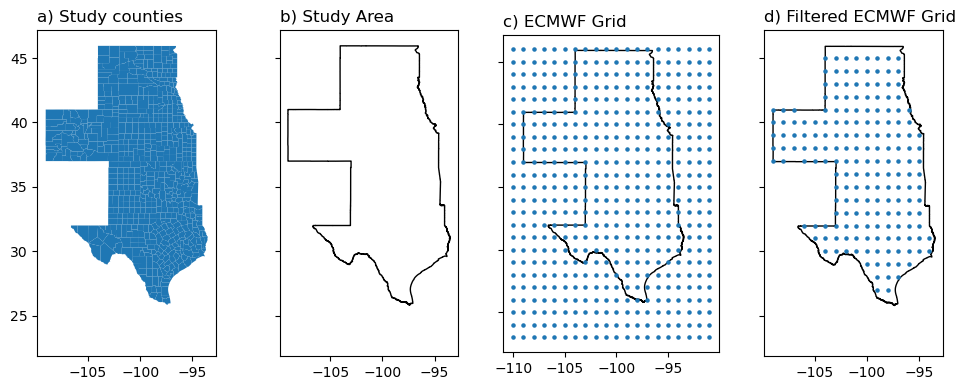

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(10, 4), sharey=True)
axs = axs.ravel()
country_gpd.plot(ax=axs[0])
axs[0].set_title("a) Study counties", loc="left")
study_area_shape.plot(ax=axs[1], facecolor="none", edgecolor="black")
axs[1].set_title("b) Study Area", loc="left")

study_area_shape.plot(ax=axs[2], color='white', edgecolor='black')
ecmwf_grid.plot(ax=axs[2], markersize=5)
axs[2].set_title("c) ECMWF Grid", loc="left")

study_area_shape.plot(ax=axs[3], color='white', edgecolor='black')
ecmwf_grid_filtered.plot(ax=axs[3], markersize=5)
axs[3].set_title("d) Filtered ECMWF Grid", loc="left")

plt.tight_layout()
plt.show()

#### Read ECMWF seasonal forecasts

In [13]:
month = "feb"
list_hindcasts = []
for filename in ["{}_2003_09".format(month), "{}_2010_16".format(month), "{}_2017_23".format(month)]:
    print("reading {}".format(filename))
    df = xr.open_dataset("../data/ECMWF/{}/ecmwf_grib/".format(country) + filename.lower() + ".grib")
    print("rough filtering coordinates, ensembles and steps until august")
    df = df.sel(latitude=slice(country_bounds[3]+2, country_bounds[1]-2), 
       longitude=slice(country_bounds[0]-2, country_bounds[2]+2),
       number=slice(0, 24), 
       step=slice(np.timedelta64(0, "D"), np.timedelta64(32 * (9 - df["time.month"].to_dataframe()["month"].unique()[0]), "D")))
    print("to dataframe")
    df = df.to_dataframe().dropna().reset_index()
    print("filter coordinates to exact study region")
    df = df.merge(filtered_coords[["latitude", "longitude"]], on=["latitude", "longitude"], how="right")
    print(df.shape)       
    print("convert to datetime")
    df["valid_time"] = pd.to_datetime(df["valid_time"])
    df["time"] = pd.to_datetime(df["time"])
    print("filter exact until august")
    ## august, although season goes until september to aggregate a the last time step from july with days from august
    df = df.loc[(df["valid_time"].dt.month <= 8) 
                & (df["time"].dt.year.between(2004, 2023))].reset_index(drop=True)
    print("Append to list")
    list_hindcasts.append(df)
    
import winsound    
winsound.Beep(1440, 200)    

reading feb_2003_09


Ignoring index file '../data/ECMWF/US/ecmwf_grib/feb_2003_09.grib.923a8.idx' incompatible with GRIB file


rough filtering coordinates, ensembles and steps until august
to dataframe
filter coordinates to exact study region
(6885375, 11)
convert to datetime
filter exact until august
Append to list
reading feb_2010_16


Ignoring index file '../data/ECMWF/US/ecmwf_grib/feb_2010_16.grib.923a8.idx' incompatible with GRIB file


rough filtering coordinates, ensembles and steps until august
to dataframe
filter coordinates to exact study region
(6885375, 11)
convert to datetime
filter exact until august
Append to list
reading feb_2017_23


Ignoring index file '../data/ECMWF/US/ecmwf_grib/feb_2017_23.grib.923a8.idx' incompatible with GRIB file


rough filtering coordinates, ensembles and steps until august
to dataframe
filter coordinates to exact study region
(6885375, 11)
convert to datetime
filter exact until august
Append to list


In [14]:
ecmwf = pd.concat(list_hindcasts, ignore_index=True)

### Checks

- Time.year.between(2004, 2023)
- valid_time.month.between(1,8)
- latitude-longitude pairs complete

In [8]:
print(ecmwf.valid_time.dt.month.unique())
print(ecmwf.groupby(["valid_time"]).size().unique())
print(ecmwf.groupby(["latitude", "longitude"]).size().unique())
print(ecmwf.groupby("time").size().unique())

[1 2 3 4 5 6 7 8]
[4575]
[107500]
[983625]


## Export to csv

In [16]:
ecmwf.shape

(19329375, 11)

In [17]:
ecmwf.time.max()

Timestamp('2023-02-01 00:00:00')

In [18]:
for ensemble_member in ecmwf.number.unique():
    temp = ecmwf.loc[ecmwf.number == ensemble_member].reset_index(drop=True)
    print("export to csv with filename ", "../data/ECMWF/{}/ecmwf_csv/ecmwf_{}_{}.csv".format(country, month, ensemble_member))
    temp.to_csv("../data/ECMWF/{}/ecmwf_csv/ecmwf_{}_{}.csv".format(country, month, ensemble_member), index=False)

export to csv with filename  ../data/ECMWF/US/ecmwf_csv/ecmwf_feb_0.csv
export to csv with filename  ../data/ECMWF/US/ecmwf_csv/ecmwf_feb_1.csv
export to csv with filename  ../data/ECMWF/US/ecmwf_csv/ecmwf_feb_2.csv
export to csv with filename  ../data/ECMWF/US/ecmwf_csv/ecmwf_feb_3.csv
export to csv with filename  ../data/ECMWF/US/ecmwf_csv/ecmwf_feb_4.csv
export to csv with filename  ../data/ECMWF/US/ecmwf_csv/ecmwf_feb_5.csv
export to csv with filename  ../data/ECMWF/US/ecmwf_csv/ecmwf_feb_6.csv
export to csv with filename  ../data/ECMWF/US/ecmwf_csv/ecmwf_feb_7.csv
export to csv with filename  ../data/ECMWF/US/ecmwf_csv/ecmwf_feb_8.csv
export to csv with filename  ../data/ECMWF/US/ecmwf_csv/ecmwf_feb_9.csv
export to csv with filename  ../data/ECMWF/US/ecmwf_csv/ecmwf_feb_10.csv
export to csv with filename  ../data/ECMWF/US/ecmwf_csv/ecmwf_feb_11.csv
export to csv with filename  ../data/ECMWF/US/ecmwf_csv/ecmwf_feb_12.csv
export to csv with filename  ../data/ECMWF/US/ecmwf_csv/ecmwf